<h1><strong>Análise de sentimentos em avaliações de e-commerce</strong></h1>


**Objetivo**:

Classificar as avaliações de e-commerce em positiva ou negativa.

*   Dataset: https://nijianmo.github.io/amazon/index.html

***Orientador:*** Thiago de Melo

***Orientando:*** Edson Brilhante

# Importando as bibliotecas

In [1]:
# Uninstall mkl for faster neural-network training time
!pip uninstall -y mkl
# Upgrade pip to ensure the latest package versions are available
!pip install -U pip
!pip install -U "mxnet-cu100<2.0.0"
!pip install autogluon
!pip install -U ipykernel

In [2]:
import numpy as np
import pandas as pd
import os
import joblib
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
import gzip
import json
import autogluon as ag
from autogluon.core.utils.loaders.load_pd import load
from autogluon.text import TextPredictor
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Importando os *datasets*

In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
    if i >= 20000:
      break
  return pd.DataFrame.from_dict(df, orient='index')

In [48]:
datasets = {}
#datasets['Amazon Fashion'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/AMAZON_FASHION_5.json.gz')
#datasets['All Beauty'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/All_Beauty_5.json.gz')
#datasets['Appliances'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Appliances_5.json.gz')
#datasets['Arts, Crafts and Sewing'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Arts_Crafts_and_Sewing_5.json.gz')
#datasets['Automotive'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Automotive_5.json.gz')
#datasets['Books'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Books_5.json.gz')
#datasets['CDs and Vinyl'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/CDs_and_Vinyl_5.json.gz')
#datasets['Cell Phones and Accessories'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Cell_Phones_and_Accessories_5.json.gz')
#datasets['Clothing, Shoes and Jewelry'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Clothing_Shoes_and_Jewelry_5.json.gz')
#datasets['Digital Music'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Digital_Music_5.json.gz')
#datasets['Electronics'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Electronics_5.json.gz')
#datasets['Gift Cards'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Gift_Cards_5.json.gz')
#datasets['Grocery and Gourmet Food'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Grocery_and_Gourmet_Food_5.json.gz')
#datasets['Home and Kitchen'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Home_and_Kitchen_5.json.gz')
#datasets['Industrial and Scientific'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Industrial_and_Scientific_5.json.gz')
#datasets['Kindle Store'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Kindle_Store_5.json.gz')
#datasets['Luxury Beauty'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Luxury_Beauty_5.json.gz')
#datasets['Magazine Subscriptions'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Magazine_Subscriptions_5.json.gz')
#datasets['Movies and TV'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Movies_and_TV_5.json.gz')
#datasets['Musical Instruments'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Musical_Instruments_5.json.gz')
#datasets['Office Products'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Office_Products_5.json.gz')
#datasets['Patio, Lawn and Garden'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Patio_Lawn_and_Garden_5.json.gz')
#datasets['Pet Supplies'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Pet_Supplies_5.json.gz')
#datasets['Prime Pantry'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Prime_Pantry_5.json.gz')
#datasets['Software'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Software_5.json.gz')
#datasets['Sports and Outdoors'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Sports_and_Outdoors_5.json.gz')
#datasets['Tools and Home Improvement'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Tools_and_Home_Improvement_5.json.gz')
#datasets['Toys and Games'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Toys_and_Games_5.json.gz')
datasets['Video Games'] = getDF('/content/drive/MyDrive/Edson Henrique/dataset/Video_Games_5.json.gz')

# Visualização dos *datasets*

In [49]:
for key, dataset in datasets.items():
  print(key)
  dataset.info()
  print('\n')

Video Games
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         20000 non-null  float64
 1   verified        20000 non-null  bool   
 2   reviewTime      20000 non-null  object 
 3   reviewerID      20000 non-null  object 
 4   asin            20000 non-null  object 
 5   reviewerName    20000 non-null  object 
 6   reviewText      19996 non-null  object 
 7   summary         19997 non-null  object 
 8   unixReviewTime  20000 non-null  int64  
 9   vote            5814 non-null   object 
 10  style           6551 non-null   object 
 11  image           100 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 1.9+ MB




# Modelagem

## Seleciona as colunas '*reviewText*' e '*overall*'

In [50]:
def select_columns(dataset):
  dataset = dataset[['reviewText', 'overall']]
  dataset = dataset.dropna()
  dataset = dataset.reset_index(drop=True)
  return dataset

In [51]:
for key, dataset in datasets.items():
  dataset= select_columns(dataset)
  datasets[key] = dataset

## Encoding

Seleciona o atributo *'overall'* e o converte da seguinte forma:



*   1, 2 e 3: negativa
*   4 e 5: positiva

In [52]:
for key, dataset in datasets.items():
  dataset['overall'] = np.where(dataset['overall'] >= 4.0, 1, 0)
  datasets[key] = dataset

## Limpando as avaliações

In [53]:
english_stopwords = list()
with open('/content/drive/MyDrive/Edson Henrique/code/stopwords/english', 'r') as a_file:
  for line in a_file:
    stripped_line = line.strip()
    english_stopwords.append(stripped_line)

excluded_words = ("not", "no",  'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'shouldn', "shouldn't",  "won't", 'wouldn', "wouldn't")
english_stopwords = [x for x in english_stopwords if x not in excluded_words]
print(english_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',

In [54]:
def limpa_texto(dataset):
  corpus = []
  for i in range (0, dataset.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', dataset['reviewText'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(english_stopwords)]
    review = ' '.join(review)
    corpus.append(review)
  return corpus

## Criando o modelo *bag of words*

In [55]:
def cria_bag_words(corpus):
  cv = CountVectorizer(max_features = 1500)
  X = cv.fit_transform(corpus).toarray()
  return X

# Treino

In [56]:
def ler_dataset_resultados():
  dir = '/content/drive/MyDrive/Edson Henrique/code/'
  filename = 'resultados.csv'
  
  if True == os.path.isfile(dir + filename):
    # load results dataset from disk
    resultados_dataset = pd.read_csv(dir + filename, index_col=0)
  else:
    result_dict = {'TextBlob': np.nan, 'Vader' : np.nan, 'Flair' : np.nan, 'AutoGluon' : np.nan, 'Auto-Sklearn' : np.nan, 'TPOT' : np.nan}
    resultados_dataset = pd.DataFrame(result_dict, index =  datasets.keys())
    # save results dataset to disk
    resultados_dataset.to_csv(dir + filename, index=True)
  return resultados_dataset

def salvar_dataset_resultados(dataset):
  dir = '/content/drive/MyDrive/Edson Henrique/code/'
  filename = 'resultados.csv'
  resultados_dataset.to_csv(dir + filename, index=True)

resultados_dataset = ler_dataset_resultados()
resultados_dataset

,TextBlob,Vader,Flair,AutoGluon,Auto-Sklearn,TPOT
Amazon Fashion,0.830696,0.844620,0.942089,0.837025,0.993671,NaN
All Beauty,0.882599,0.905015,0.952508,0.957265,0.991453,NaN
Appliances,0.796662,0.797541,0.628898,0.785088,0.995614,NaN
"Arts, Crafts and Sewing",0.830063,0.848157,0.939764,0.905203,0.905203,NaN
Automotive,0.787817,0.804407,0.906672,0.876219,0.876219,NaN
Books,0.821405,0.807102,0.909827,0.884471,0.858715,NaN
CDs and Vinyl,0.850028,0.837976,0.883783,0.884250,0.884250,NaN
Cell Phones and Accessories,0.732223,0.767077,0.861436,0.846750,0.273500,NaN
"Clothing, Shoes and Jewelry",0.789640,0.823506,0.901308,0.848485,0.816429,NaN
Digital Music,0.843594,0.854530,0.936968,0.952476,0.952476,NaN


## TextBlob

In [57]:
# f_categorizar_blob = (lambda x: 1 if x > 0 else 0)

# def classificar_blob(dataset):
#   dataset['TextBlob'] = np.nan
#   for i in range (0, dataset.shape[0]):
#     blob = TextBlob(dataset['reviewText'].values[i])
#     dataset.iloc[i,2] = f_categorizar_blob(blob.sentiment.polarity)
#   return dataset

In [58]:
# dir = '/content/drive/MyDrive/Edson Henrique/model_save/'

# for key, dataset in datasets.items():
#   filename = key + '_TextBlob.csv'

#   if True == os.path.isfile(dir + filename):
#     # load dataset from disk
#     dataset = pd.read_csv(dir + filename)
#   else:
#     dataset = classificar_blob(dataset)
#     # save new dataset to disk
#     dataset.to_csv(dir + filename)
#     datasets[key] = dataset

#   y_true = dataset['overall'].values
#   y_pred = dataset['TextBlob'].values

#   print('Classificador TextBlob')
#   print('Dataset: ', key)

#   print('Matriz de confusão')
#   print(confusion_matrix(y_true, y_pred))

#   print('\nMétricas')
#   print(classification_report(y_true, y_pred, digits=3))

#   print('\nScore')
#   score = accuracy_score(y_true, y_pred)
#   print(score)
#   print('\n')
  
#   if pd.isna(resultados_dataset.at[key, 'TextBlob']):
#     resultados_dataset.loc[key]['TextBlob'] = score

# salvar_dataset_resultados(resultados_dataset)

## vaderSentiment

In [59]:
# f_categorizar_vader = (lambda x: 1 if x > 0 else 0)

# def classificar_vaderSentiment(dataset):
#   dataset['vaderSentiment'] = np.nan
#   analyzer = SentimentIntensityAnalyzer()
#   for i in range (0, dataset.shape[0]):
#     vs = analyzer.polarity_scores(dataset['reviewText'].values[i])
#     dataset.iloc[i,3] = f_categorizar_vader(vs['compound'])
#   return dataset

In [60]:
# dir = '/content/drive/MyDrive/Edson Henrique/model_save/'

# for key, dataset in datasets.items():
#   filename = key + '_vaderSentiment.csv'

#   if True == os.path.isfile(dir + filename):
#     # load dataset from disk
#     dataset = pd.read_csv(dir + filename)
#   else:
#     dataset = classificar_vaderSentiment(dataset)
#     # save new dataset to disk
#     dataset.to_csv(dir + filename)
#     datasets[key] = dataset

#   y_true = dataset['overall'].values
#   y_pred = dataset['vaderSentiment'].values

#   print('Classificador vaderSentiment')
#   print('Dataset: ', key)

#   print('Matriz de confusão')
#   print(confusion_matrix(y_true, y_pred))

#   print('\nMétricas')
#   print(classification_report(y_true, y_pred, digits=3))

#   print('\nScore')
#   score = accuracy_score(y_true, y_pred)
#   print(score)
#   print('\n')

#   if pd.isna(resultados_dataset.at[key, 'Vader']):
#     resultados_dataset.loc[key]['Vader'] = score

# salvar_dataset_resultados(resultados_dataset)

## Flair

In [61]:
# def flair_sentiment(texts, classifier):
#   sentences = [Sentence(text) for text in texts]
#   classifier.predict(sentences, mini_batch_size=32)
#   return [
#           (sent.labels[0].score, sent.labels[0].value)
#           for sent in sentences
#           ]

# def classificar_flair(dataset):
#   dataset['Flair'] = np.nan
#   classifier = TextClassifier.load('sentiment-fast')
#   sentiments = flair_sentiment(dataset['reviewText'].values, classifier)
#   dataset['Flair'] = [sent[1] for sent in sentiments]
#   dataset['Flair'] = pd.Categorical(dataset['Flair'])
#   dataset['Flair'] = dataset['Flair'].cat.rename_categories({'NEGATIVE': 0, 'POSITIVE': 1})
#   return dataset

In [62]:
# dir = '/content/drive/MyDrive/Edson Henrique/model_save/'

# for key, dataset in datasets.items():
#   filename = key + '_Flair.csv'

#   if True == os.path.isfile(dir + filename):
#     # load dataset from disk
#     dataset = pd.read_csv(dir + filename)
#   else:
#     dataset = classificar_flair(dataset)
#     # save new dataset to disk
#     dataset.to_csv(dir + filename)
#     datasets[key] = dataset

#   y_true = dataset['overall'].values
#   y_pred = dataset['Flair'].values

#   print('Classificador Flair')
#   print('Dataset: ', key)

#   print('Matriz de confusão')
#   print(confusion_matrix(y_true, y_pred))

#   print('\nMétricas')
#   print(classification_report(y_true, y_pred, digits=3))

#   print('\nScore')
#   score = accuracy_score(y_true, y_pred)
#   print(score)
#   print('\n')
  
#   if pd.isna(resultados_dataset.at[key, 'Flair']):
#     resultados_dataset.loc[key]['Flair'] = score

# salvar_dataset_resultados(resultados_dataset)

## AutoGluon

In [63]:
dir = '/content/drive/MyDrive/Edson Henrique/model_save/'

def classificar_autogluon(dataset):
  #cls = TextPredictor(label='overall', eval_metric='acc', path=(dir + modelname))
  cls = TextPredictor(label='overall', eval_metric='acc', path=None)

  # Dividindo o dataset em treino e teste
  train_data, test_data = train_test_split(dataset, test_size = 0.2, random_state = 0)
  cls.fit(train_data, time_limit=60)
  y_pred = cls.predict(test_data)
  y_test = test_data.iloc[:, -1].values
  return y_pred, y_test

No path specified. Models will be saved in: "AutogluonModels/ag-20220221_213104/"
Problem Type="binary"
Column Types:
   - "reviewText": text
   - "overall": categorical

The GluonNLP V0 backend is used. We will use 2 cpus and 1 gpus to train each trial.


All Logs will be saved to /content/AutogluonModels/ag-20220221_213104/task0/training.log


Fitting and transforming the train data...
Done! Preprocessor saved to /content/AutogluonModels/ag-20220221_213104/task0/preprocessor.pkl
Process dev set...
Done!
Max length for chunking text: 512, Stochastic chunk: Train-False/Test-False, Test #repeat: 1.
#Total Params/Fixed Params=108990466/0
Using gradient accumulation. Global batch size = 128
Local training results will be saved to /content/AutogluonModels/ag-20220221_213104/task0/results_local.jsonl.
[Iter 6/1130, Epoch 0] train loss=6.53e-01, gnorm=4.68e+00, lr=5.31e-06, #samples processed=768, #sample per second=12.34. ETA=194.34min
[Iter 12/1130, Epoch 0] train loss=4.94e-01, gnorm=1.95e+00, lr=1.06e-05, #samples processed=768, #sample per second=13.33. ETA=186.09min
[Iter 18/1130, Epoch 0] train loss=4.48e-01, gnorm=1.47e+00, lr=1.59e-05, #samples processed=768, #sample per second=12.32. ETA=187.56min
[Iter 23/1130, Epoch 0] valid f1=9.2603e-01, mcc=4.4418e-01, roc_auc=8.6552e-01, accuracy=8.7000e-01, log_loss=3.5551e-01, time

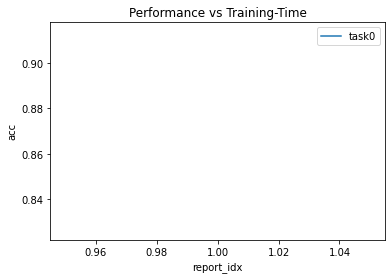

Training completed. Auto-saving to "AutogluonModels/ag-20220221_213104/". For loading the model, you can use `predictor = TextPredictor.load("AutogluonModels/ag-20220221_213104/")`


Classificador AutoGluon
Dataset:  Video Games
Matriz de confusão
[[ 209  478]
 [  37 3276]]

Métricas
              precision    recall  f1-score   support

           0      0.850     0.304     0.448       687
           1      0.873     0.989     0.927      3313

    accuracy                          0.871      4000
   macro avg      0.861     0.647     0.688      4000
weighted avg      0.869     0.871     0.845      4000


Score
0.87125




In [64]:
for key, dataset in datasets.items():
  y_pred, y_test = classificar_autogluon(dataset)
  
  print('Classificador AutoGluon')
  print('Dataset: ', key)

  print('Matriz de confusão')
  print(confusion_matrix(y_test, y_pred))

  print('\nMétricas')
  print(classification_report(y_test, y_pred, digits=3))

  print('\nScore')
  score = accuracy_score(y_test, y_pred)
  print(score)
  print('\n')
  
  if pd.isna(resultados_dataset.at[key, 'AutoGluon']):
    resultados_dataset.loc[key]['AutoGluon'] = score
  salvar_dataset_resultados(resultados_dataset)

## Auto-Sklearn

In [65]:
# def classificar_auto_sklearn(dataset):
#   cls = autosklearn.classification.AutoSklearnClassifier(n_jobs=8, time_left_for_this_task=60)
#   corpus = limpa_texto(dataset)
#   X = cria_bag_words(corpus)
#   y = dataset.iloc[:, -1].values

#   # Dividindo o dataset em treino e teste
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#   cls.fit(X_train, y_train)
#   y_pred = cls.predict(X_test)
#   return y_pred, y_test

In [66]:
# dir = '/content/drive/MyDrive/Edson Henrique/model_save/'

# for key, dataset in datasets.items():
#   filename = key + '_Auto_Sklearn.sav'
  
#   if True == os.path.isfile(dir + filename):
#     # load model from disk
#     clf_auto_sklearn = joblib.load(dir + filename)
#     corpus = limpa_texto(dataset) # todo
#     X = cria_bag_words(corpus) # todo
#     y = dataset.iloc[:, -1].values # todo
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#     y_pred = clf_auto_sklearn.predict(X_test) # todo
#   else:
#     y_pred, y_test = classificar_auto_sklearn(dataset)
  
#   print('Classificador Auto-Sklearn')
#   print('Dataset: ', key)

#   print('Matriz de confusão')
#   print(confusion_matrix(y_test, y_pred))

#   print('\nMétricas')
#   print(classification_report(y_test, y_pred, digits=3))

#   print('\nScore')
#   score = accuracy_score(y_test, y_pred)
#   print(score)
#   print('\n')
  
#   if pd.isna(resultados_dataset.at[key, 'Auto-Sklearn']):
#     resultados_dataset.loc[key]['Auto-Sklearn'] = score

# salvar_dataset_resultados(resultados_dataset)

## TPOT

In [67]:
# def classificar_tpot(dataset):
#   #tpot = TPOTClassifier(max_time_mins = 5, random_state=0)
#   tpot = TPOTClassifier(max_time_mins = 5, n_jobs = -2, random_state=0)
#   corpus = limpa_texto(dataset)
#   X = cria_bag_words(corpus)
#   y = dataset.iloc[:, -1].values

#   # Dividindo o dataset em treino e teste
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#   tpot.fit(X_train, y_train)
#   y_pred = tpot.predict(X_test)
#   return y_pred, y_test

In [68]:
# for key, dataset in datasets.items():
#   y_pred, y_test = classificar_tpot(dataset)
  
#   print('Classificador TPOT')
#   print('Dataset: ', key)
  
#   print('Matriz de confusão')
#   print(confusion_matrix(y_test, y_pred))
  
#   print('\nMétricas')
#   print(classification_report(y_test, y_pred, digits=3))
  
#   print('\nScore')
#   score = accuracy_score(y_test, y_pred)
#   print(score)
#   print('\n')
  
#   if pd.isna(resultados_dataset.at[key, 'TPOT']):
#     resultados_dataset.loc[key]['TPOT'] = score
  
#   salvar_dataset_resultados(resultados_dataset)

# Resultados

In [69]:
resultados_dataset

,TextBlob,Vader,Flair,AutoGluon,Auto-Sklearn,TPOT
Amazon Fashion,0.830696,0.844620,0.942089,0.837025,0.993671,NaN
All Beauty,0.882599,0.905015,0.952508,0.957265,0.991453,NaN
Appliances,0.796662,0.797541,0.628898,0.785088,0.995614,NaN
"Arts, Crafts and Sewing",0.830063,0.848157,0.939764,0.905203,0.905203,NaN
Automotive,0.787817,0.804407,0.906672,0.876219,0.876219,NaN
Books,0.821405,0.807102,0.909827,0.884471,0.858715,NaN
CDs and Vinyl,0.850028,0.837976,0.883783,0.884250,0.884250,NaN
Cell Phones and Accessories,0.732223,0.767077,0.861436,0.846750,0.273500,NaN
"Clothing, Shoes and Jewelry",0.789640,0.823506,0.901308,0.848485,0.816429,NaN
Digital Music,0.843594,0.854530,0.936968,0.952476,0.952476,NaN
